#Лабораторная работа по курсу

#Загружаем данные

In [1]:
# скачиваем данные
!wget 'https://archive.ics.uci.edu/static/public/40/flags.zip'

--2024-11-25 12:18:07--  https://archive.ics.uci.edu/static/public/40/flags.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘flags.zip’

flags.zip               [ <=>                ]   5.72K  --.-KB/s    in 0s      

2024-11-25 12:18:07 (76.1 MB/s) - ‘flags.zip’ saved [5862]



In [2]:
import zipfile

# Путь к zip-архиву
archive_path = '/content/flags.zip'

# Распаковываем zip-архив
with zipfile.ZipFile(archive_path, 'r') as zip_ref:
    zip_ref.extractall()

In [3]:
import pandas as pd
import numpy as np

cols = ['name','landmass','zone','area','population','language','religion','bars','stripes',
       'colours','red','green','blue','gold','white','black','orange','mainhue','circles',
       'crosses','saltires','quarters','sunstars','crescent','triangle','icon','animate',
       'text','topleft','botright']

# загружаю датасет
data = pd.read_csv('/content/flag.data', header=None, names=cols)
data.head()

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
0,Afghanistan,5,1,648,16,10,2,0,3,5,...,0,0,1,0,0,1,0,0,black,green
1,Albania,3,1,29,3,6,6,0,0,3,...,0,0,1,0,0,0,1,0,red,red
2,Algeria,4,1,2388,20,8,2,2,0,3,...,0,0,1,1,0,0,0,0,green,white
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red


#Анализ данных

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 30 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        194 non-null    object
 1   landmass    194 non-null    int64 
 2   zone        194 non-null    int64 
 3   area        194 non-null    int64 
 4   population  194 non-null    int64 
 5   language    194 non-null    int64 
 6   religion    194 non-null    int64 
 7   bars        194 non-null    int64 
 8   stripes     194 non-null    int64 
 9   colours     194 non-null    int64 
 10  red         194 non-null    int64 
 11  green       194 non-null    int64 
 12  blue        194 non-null    int64 
 13  gold        194 non-null    int64 
 14  white       194 non-null    int64 
 15  black       194 non-null    int64 
 16  orange      194 non-null    int64 
 17  mainhue     194 non-null    object
 18  circles     194 non-null    int64 
 19  crosses     194 non-null    int64 
 20  saltires  

In [5]:
black_list = ['name'] # имя страны не рассматриваем
categoricals = ['landmass','zone','language','mainhue','topleft','botright']
dummies = ['red','green','blue','gold','white','black','orange','crescent','triangle','icon','animate','text']
continious = ['area', 'population', 'bars', 'stripes', 'colours','circles', 'crosses', 'saltires', 'quarters', 'sunstars']
target = 'religion'

In [6]:
data[continious].describe()

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars
count,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000,194.000000
mean,700.046392,23.268041,0.453608,1.551546,3.463918,0.170103,0.149485,0.092784,0.149485,1.386598
std,2170.927932,91.934085,1.038339,2.328005,1.300154,0.463075,0.385387,0.290879,0.435860,4.396186
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,111.000000,4.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,471.250000,14.000000,0.000000,3.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,22402.000000,1008.000000,5.000000,14.000000,8.000000,4.000000,2.000000,1.000000,4.000000,50.000000


In [7]:
data[data.area == 0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue
33,Cayman-Islands,1,4,0,0,1,1,0,0,6,...,1,1,4,0,0,1,1,1,white,blue
41,Cook-Islands,6,3,0,0,1,1,0,0,4,...,1,1,15,0,0,0,0,0,white,blue
48,Dominica,1,4,0,0,1,1,0,0,6,...,0,0,10,0,0,0,1,0,green,green


In [8]:
data[data.population==0]

,name,landmass,zone,area,population,language,religion,bars,stripes,colours,...,saltires,quarters,sunstars,crescent,triangle,icon,animate,text,topleft,botright
3,American-Samoa,6,3,0,0,1,1,0,0,5,...,0,0,0,0,1,1,1,0,blue,red
4,Andorra,3,1,0,0,6,0,3,0,3,...,0,0,0,0,0,0,0,0,blue,red
6,Anguilla,1,4,0,0,1,1,0,1,3,...,0,0,0,0,0,0,1,0,white,blue
7,Antigua-Barbuda,1,4,0,0,1,1,0,1,5,...,0,0,1,0,1,0,0,0,black,red
12,Bahamas,1,4,19,0,1,1,0,3,3,...,0,0,0,0,1,0,0,0,blue,blue
13,Bahrain,5,1,1,0,8,2,0,0,2,...,0,0,0,0,0,0,0,0,white,red
15,Barbados,1,4,0,0,1,1,3,0,3,...,0,0,0,0,0,1,0,0,blue,blue
17,Belize,1,4,23,0,1,1,0,2,8,...,0,0,0,0,0,1,1,1,red,red
19,Bermuda,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,0,white,red
24,British-Virgin-Isles,1,4,0,0,1,1,0,0,6,...,1,1,0,0,0,1,1,1,white,blue


In [9]:
data[dummies].agg(['min','max', 'nunique', 'mean'])

,red,green,blue,gold,white,black,orange,crescent,triangle,icon,animate,text
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
nunique,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,0.78866,0.469072,0.510309,0.469072,0.752577,0.268041,0.134021,0.056701,0.139175,0.252577,0.201031,0.082474


In [10]:
dummies

['red',
 'green',
 'blue',
 'gold',
 'white',
 'black',
 'orange',
 'crescent',
 'triangle',
 'icon',
 'animate',
 'text']

In [11]:
data[continious]

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars
0,648,16,0,3,5,0,0,0,0,1
1,29,3,0,0,3,0,0,0,0,1
2,2388,20,2,0,3,0,0,0,0,1
3,0,0,0,0,5,0,0,0,0,0
4,0,0,3,0,3,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
189,3,0,0,0,3,0,0,0,1,5
190,256,22,0,3,4,0,0,0,0,1
191,905,28,0,0,4,1,0,0,0,0
192,753,6,3,0,4,0,0,0,0,0


In [12]:
y = data[target]
y.head()

,religion
0,2
1,6
2,2
3,1
4,0


In [75]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [14]:
def union_classes(x):
    if x in [3,4,7]:
        return 3
    elif x==6:
        return 5
    elif x==5:
        return 4
    else:
        return x

In [15]:
data['religion'] = data['religion'].apply(union_classes)

In [16]:
y = data['religion']
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [17]:
X = pd.concat([data[continious], data[dummies],
               pd.get_dummies(data[categoricals])],
               axis=1
             )
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 48 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   area             194 non-null    int64
 1   population       194 non-null    int64
 2   bars             194 non-null    int64
 3   stripes          194 non-null    int64
 4   colours          194 non-null    int64
 5   circles          194 non-null    int64
 6   crosses          194 non-null    int64
 7   saltires         194 non-null    int64
 8   quarters         194 non-null    int64
 9   sunstars         194 non-null    int64
 10  red              194 non-null    int64
 11  green            194 non-null    int64
 12  blue             194 non-null    int64
 13  gold             194 non-null    int64
 14  white            194 non-null    int64
 15  black            194 non-null    int64
 16  orange           194 non-null    int64
 17  crescent         194 non-null    int64
 18  triangle  

#Подготовим данные

In [18]:
# разобрьем данные на тест и трейн
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
                                                   )

#RandomForestClassifier

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [20]:
# построим модель RandomForestClassifier по умолчанию
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [21]:
# построим модель StratifiedKFold
skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

In [22]:
score_on_train = 0
for trn_idx,tst_idx in skf.split(X_train, y_train):
    X_train_fold, y_train_fold = X.iloc[trn_idx], y.iloc[trn_idx]
    X_test_fold, y_test_fold = X.iloc[tst_idx], y.iloc[tst_idx]
    rfc.fit(X_train_fold, y_train_fold)
    score_on_train += rfc.score(X_test_fold, y_test_fold)

rfc.fit(X_train, y_train)
print(f'score_on_train={score_on_train/3 :.3f}')
print(f'score_on_test ={rfc.score(X_test, y_test) :.3f}')

score_on_train=0.665
score_on_test =0.641


Подберем лучшие параметры для RandomForestClassifier

In [23]:
from sklearn.model_selection import GridSearchCV

In [24]:
# зададим возможные параметры
param_grid = {'max_depth': [6, 8],
              'max_features': [None],
              'max_leaf_nodes': [6, 8, 10],
              'min_samples_leaf': [4, 6],
              'min_samples_split': [4, 6],
              'n_estimators': [50, 60, 70]
             }

In [25]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [26]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [27]:
# обучим
rfc_grid.fit(X_train, y_train)
rfc_grid

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [6, 8], 'max_features': [None],
                         'max_leaf_nodes': [6, 8, 10],
                         'min_samples_leaf': [4, 6],
                         'min_samples_split': [4, 6],
                         'n_estimators': [50, 60, 70]},
             verbose=True)

In [28]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 6,
 'max_features': None,
 'max_leaf_nodes': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 4,
 'n_estimators': 60}

In [29]:
# получим и обучим нашу лучшую модель
rfc_best = rfc_grid.best_estimator_
rfc_best.fit(X_train, y_train)
rfc_best

RandomForestClassifier(max_depth=6, max_features=None, max_leaf_nodes=8,
                       min_samples_leaf=4, min_samples_split=4, n_estimators=60,
                       n_jobs=-1, random_state=42)

In [30]:
# получим метрики
score_on_train = rfc_best.score(X_train, y_train)
score_on_test = rfc_best.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=0.781
score_on_test =0.615


In [31]:
X_train.shape

(155, 48)

In [32]:
# посмотрим на важность признаков
importances = rfc_best.feature_importances_
importances

array([0.06111736, 0.01983508, 0.00453538, 0.00238812, 0.00439709,
       0.00289835, 0.01902233, 0.        , 0.00109262, 0.00137482,
       0.        , 0.00615161, 0.01949417, 0.00801693, 0.00371421,
       0.00320483, 0.        , 0.        , 0.        , 0.        ,
       0.00752129, 0.        , 0.35263928, 0.07266554, 0.40534721,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00103958, 0.        , 0.        , 0.0012772 ,
       0.        , 0.        , 0.        , 0.        , 0.00112495,
       0.        , 0.00114204, 0.        ])

In [33]:
# построим список наших признаков
feature_list = list(X_train.columns)
feature_list[:5]

['area', 'population', 'bars', 'stripes', 'colours']

In [34]:
# соберем df из feature и importance
feature_importance = pd.DataFrame({'feature':feature_list, 'importance':importances})
feature_importance.head()

,feature,importance
0,area,0.061117
1,population,0.019835
2,bars,0.004535
3,stripes,0.002388
4,colours,0.004397


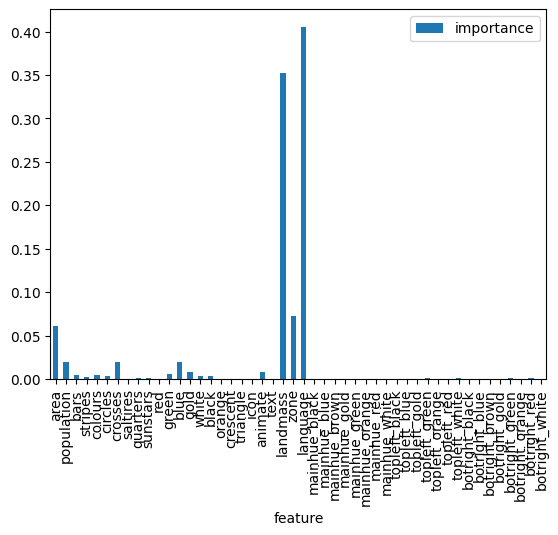

In [35]:
# посмотрим
import matplotlib.pyplot as plt

feature_importance.plot(x='feature',
                        y='importance',
                        kind='bar'
                       )
plt.show()

Определение избыточной выборки

In [36]:
# оставим только самые значимые признаки
cols = ['area', 'landmass', 'zone', 'language']

In [37]:
# зададим возможные параметры
param_grid = {'max_depth': [4, 5],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [9, 12, 15],
              'min_samples_leaf': [9],
              'min_samples_split': [7],
              'n_estimators': [150, 200, 250]
             }

In [38]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [39]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [40]:
# обучим
rfc_grid.fit(X_train[cols], y_train)
rfc_grid

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 5],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [9, 12, 15], 'min_samples_leaf': [9],
                         'min_samples_split': [7],
                         'n_estimators': [150, 200, 250]},
             verbose=True)

In [41]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 4,
 'max_features': 'sqrt',
 'max_leaf_nodes': 9,
 'min_samples_leaf': 9,
 'min_samples_split': 7,
 'n_estimators': 250}

In [42]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best = rfc_grid.best_estimator_
rfc_best.fit(X_train[cols], y_train)
rfc_best

RandomForestClassifier(max_depth=4, max_leaf_nodes=9, min_samples_leaf=9,
                       min_samples_split=7, n_estimators=250, n_jobs=-1,
                       random_state=42)

In [43]:
# получим метрики
score_on_train = rfc_best.score(X_train[cols], y_train)
score_on_test = rfc_best.score(X_test[cols], y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=0.723
score_on_test =0.538


Добавим рандомный признак

In [44]:
# рандомный признак random_feauture
X_random = X.copy()
X_random['random_feauture'] = np.random.random(X.shape[0])
X_random.head(2)

,area,population,bars,stripes,colours,circles,crosses,saltires,quarters,sunstars,...,topleft_white,botright_black,botright_blue,botright_brown,botright_gold,botright_green,botright_orange,botright_red,botright_white,random_feauture
0,648,16,0,3,5,0,0,0,0,1,...,False,False,False,False,False,True,False,False,False,0.373420
1,29,3,0,0,3,0,0,0,0,1,...,False,False,False,False,False,False,False,True,False,0.209856


In [45]:
# разобрьем данные на тест и трейн
from sklearn.model_selection import train_test_split

X_train_random, X_test_random, y_train, y_test = train_test_split(X_random, y,
                                                                  test_size=0.2,
                                                                  stratify=y,
                                                                  random_state=42
                                                                 )

In [46]:
# зададим возможные параметры
param_grid = {'max_depth': [3, 6, 9],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [10, 15, 20],
              'min_samples_leaf': [2, 3, 6],
              'min_samples_split': [6, 8],
              'n_estimators': [50, 100]
             }

In [47]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [48]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [49]:
# обучим
rfc_grid.fit(X_train_random, y_train)
rfc_grid

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [3, 6, 9],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [10, 15, 20],
                         'min_samples_leaf': [2, 3, 6],
                         'min_samples_split': [6, 8],
                         'n_estimators': [50, 100]},
             verbose=True)

In [50]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 2,
 'min_samples_split': 8,
 'n_estimators': 100}

In [51]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best = rfc_grid.best_estimator_
rfc_best.fit(X_train_random, y_train)
rfc_best

RandomForestClassifier(max_depth=9, max_features=None, max_leaf_nodes=10,
                       min_samples_leaf=2, min_samples_split=8, n_jobs=-1,
                       random_state=42)

In [52]:
# получим метрики
score_on_train = rfc_best.score(X_train_random, y_train)
score_on_test = rfc_best.score(X_test_random, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=0.826
score_on_test =0.615


In [53]:
# посмотрим на важность признаков
importances = rfc_best.feature_importances_
importances

array([0.05303128, 0.03473162, 0.0098091 , 0.00647075, 0.01559586,
       0.0065167 , 0.01593069, 0.0005858 , 0.00355734, 0.00498966,
       0.00100628, 0.00669834, 0.02111871, 0.00581452, 0.00441749,
       0.00326371, 0.00155271, 0.0005367 , 0.        , 0.00350625,
       0.00824705, 0.        , 0.30544935, 0.06130649, 0.37950533,
       0.        , 0.00099567, 0.        , 0.0025487 , 0.        ,
       0.        , 0.00048799, 0.00647211, 0.        , 0.        ,
       0.        , 0.00223591, 0.        , 0.        , 0.00177613,
       0.        , 0.00105001, 0.        , 0.0005471 , 0.00323672,
       0.        , 0.0038219 , 0.00134917, 0.02183684])

In [54]:
# построим список наших признаков
feature_list = list(X_train_random.columns)
feature_list[:5]

['area', 'population', 'bars', 'stripes', 'colours']

In [55]:
# соберем df из feature и importance
feature_importance = pd.DataFrame({'feature':feature_list, 'importance':importances})
feature_importance.head()

,feature,importance
0,area,0.053031
1,population,0.034732
2,bars,0.009809
3,stripes,0.006471
4,colours,0.015596


In [56]:
# отсортируем
feature_importance.sort_values(by='importance', ascending=False, inplace=True)
feature_importance[:6]

,feature,importance
24,language,0.379505
22,landmass,0.305449
23,zone,0.061306
0,area,0.053031
1,population,0.034732
48,random_feauture,0.021837


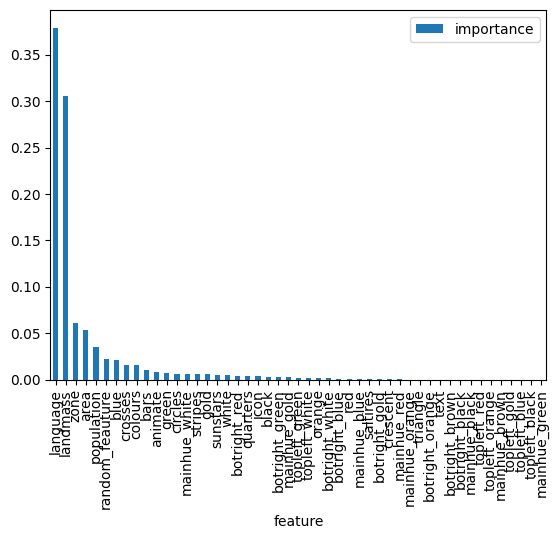

In [57]:
# посмотрим
import matplotlib.pyplot as plt

feature_importance.plot(x='feature',
                        y='importance',
                        kind='bar'
                       )
plt.show()

In [58]:
# оставим только самые значимые признаки
cols = ['language', 'landmass', 'area', 'zone', 'population']

In [59]:
# зададим возможные параметры
param_grid = {'max_depth': [6, 9, 12],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [15, 20, 25],
              'min_samples_leaf': [3, 6],
              'min_samples_split': [6, 8, 12],
              'n_estimators': [10, 50]
             }

In [60]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [61]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [62]:
# обучим
rfc_grid.fit(X_train[cols], y_train)
rfc_grid

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [6, 9, 12],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [15, 20, 25],
                         'min_samples_leaf': [3, 6],
                         'min_samples_split': [6, 8, 12],
                         'n_estimators': [10, 50]},
             verbose=True)

In [63]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 9,
 'max_features': 'sqrt',
 'max_leaf_nodes': 20,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'n_estimators': 10}

In [64]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best = rfc_grid.best_estimator_
rfc_best.fit(X_train[cols], y_train)
rfc_best


RandomForestClassifier(max_depth=9, max_leaf_nodes=20, min_samples_leaf=3,
                       min_samples_split=6, n_estimators=10, n_jobs=-1,
                       random_state=42)

In [65]:
# получим метрики
score_on_train = rfc_best.score(X_train[cols], y_train)
score_on_test = rfc_best.score(X_test[cols], y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=0.832
score_on_test =0.590


#Попробуем сбалансировать наши данные

Используем SMOTE

In [67]:
!pip install imbalanced-learn

In [69]:
# разобрьем данные на тест и трейн
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42
                                                   )

In [70]:
y_train

,religion
183,1
53,4
162,2
23,0
110,2
...,...
168,3
39,2
78,3
48,1


In [76]:
y.value_counts()

,count
religion,
1,60
0,40
2,36
4,27
3,16
5,15


In [73]:
religions = [0, 1, 2, 3, 4, 5]
for relign in religions:
    print(f'religions={relign}: {sum(y_train == relign)}')

religions=0: 32
religions=1: 48
religions=2: 29
religions=3: 13
religions=4: 21
religions=5: 12


In [128]:
from imblearn.over_sampling import SMOTE

In [129]:
sm = SMOTE(
           sampling_strategy='auto',  # стратегия выборки. 'auto' означает увеличение
                                      # меньшего класса до размера большинственного.
           random_state=42,           # зерно для генератора случайных чисел.
           k_neighbors=5,             # количество ближайших соседей для создания
                                      # синтетических примеров.
           n_jobs=1                   # Количество ядер для параллельной работы.
                                      # -1 означает использование всех доступных ядер.
          )

In [130]:
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_smote/base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [131]:
for relign in religions:
    print(f'religions={relign}: {sum(y_train_sm == relign)}')

print(X_train_sm.shape, y_train_sm.shape)

religions=0: 48
religions=1: 48
religions=2: 48
religions=3: 48
religions=4: 48
religions=5: 48
(288, 48) (288,)


In [132]:
# зададим возможные параметры
param_grid = {'max_depth': [9, 12],
              'max_features': ['sqrt', 'log2', None],
              'max_leaf_nodes': [25, 50, 75],
              'min_samples_leaf': [3, 9],
              'min_samples_split': [6, 9, 12],
              'n_estimators': [200, 500]
             }

In [133]:
# построим модель RandomForestClassifier
rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

In [134]:
# построим GridSearchCV модель
rfc_grid = GridSearchCV(rfc, param_grid=param_grid, cv=5, verbose=True, n_jobs=-1)

In [ ]:
# обучим
rfc_grid.fit(X_train_sm, y_train_sm)
rfc_grid

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


In [121]:
# получим наши лучшие параметры
best_params = rfc_grid.best_params_
best_params

{'max_depth': 9,
 'max_features': 'log2',
 'max_leaf_nodes': 25,
 'min_samples_leaf': 6,
 'min_samples_split': 6,
 'n_estimators': 500}

In [122]:
# получим и обучим нашу лучшую модель на меньшем числе признаков
rfc_best_sm = rfc_grid.best_estimator_
rfc_best_sm.fit(X_train_sm, y_train_sm)
rfc_best_sm

RandomForestClassifier(max_depth=9, max_features='log2', max_leaf_nodes=25,
                       min_samples_leaf=6, min_samples_split=6,
                       n_estimators=500, n_jobs=-1, random_state=42)

In [123]:
# получим метрики
score_on_train = rfc_best_sm.score(X_train_sm, y_train_sm)
score_on_test = rfc_best_sm.score(X_test, y_test)

print(f'score_on_train={score_on_train :.3f}')
print(f'score_on_test ={score_on_test :.3f}')

score_on_train=0.875
score_on_test =0.641


In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
X_train_ad, y_train_ad = adasyn.fit_resample(X_train, y_train)

In [ ]:
for relign in religions:
    print(f'religions={relign}: {sum(y_train_ad == relign)}')

print(X_train_ad.shape, y_train_ad.shape)